In [23]:
# Machine learning
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.linear_model import LinearRegression

# Data science
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn

# Visualization
implet seaborn as sn
import matplotlib.pyplot as plt

# Other
import pickle
import os

In [12]:
# Train beauty rating predictors
# SCUT_encodings = np.load('SCUT-encodings.npy')
# SCUT_labels = np.load('SCUT-labels.npy')

# Load and train Neural Network
# network = MLPRegressor(validation_fraction = 0, solver='adam', max_iter= 1000).fit(SCUT_encodings, SCUT_labels)

# Load and train linear regression model
# linreg = LinearRegression().fit(SCUT_encodings, SCUT_labels)

network = pickle.load(open('nn.pkl', 'rb'))
linreg = pickle.load(open('lr.pkl', 'rb'))

In [3]:
pic_encodings, pic_metadata = np.load("encodings/pics_1425-050720.pkl", allow_pickle=True)
selfie_encodings, selfie_metadata = np.load("encodings/selfies_1647-050720.pkl", allow_pickle=True)
roastme_encodings, roast_metadata = np.load("encodings/roastme_1901-050820.pkl", allow_pickle=True)

In [13]:
# Predict ratings with linear regression model
lr_pic_ratings = linreg.predict(pic_encodings)
lr_selfie_ratings = linreg.predict(selfie_encodings)
lr_roastme_ratings =  linreg.predict(roastme_encodings)

# Predict ratings with Neural Network
nn_pic_ratings = network.predict(pic_encodings)
nn_selfie_ratings = network.predict(selfie_encodings)
nn_roastme_ratings = network.predict(roastme_encodings)

In [14]:
# Build dataframes from data
scores = lambda metadata: list(zip(*metadata))[2]  # get scores from metedata
pics_data = np.vstack((scores(pic_metadata), lr_pic_ratings, nn_pic_ratings)).T
selfies_data = np.vstack((scores(selfie_metadata), lr_selfie_ratings, nn_selfie_ratings)).T
roastme_data = np.vstack((scores(roast_metadata), lr_roastme_ratings, nn_roastme_ratings)).T

column_labels = ['Post Score', 'Lin Regr. Rating', 'NN Rating']
pics = pd.DataFrame(data=pics_data, columns=column_labels)
selfies = pd.DataFrame(data=selfies_data, columns=column_labels)
roastme = pd.DataFrame(data=roastme_data, columns=column_labels)

In [21]:
correlation")
print(roastme.corr()['Post Score'])

r/pics correlation
Post Score          1.000000
Lin Regr. Rating    0.014403
NN Rating           0.014867
Name: Post Score, dtype: float64


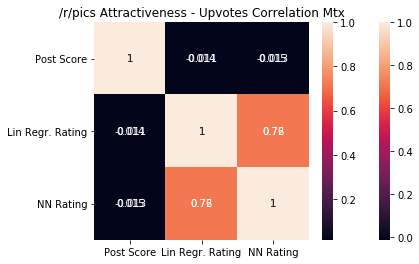

In [29]:
sn.heatmap(pics.corr(), annot=True)
plt.title('/r/pics Attractiveness - Upvotes Correlation Mtx')
sn.heatmap(roastme.corr(), annot=True)
plt.title('/r/pics Attractiveness - Upvotes Correlation Mtx')
plt.show()